In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import glob
import zipfile
import os
from keras import models, layers
import random
import matplotlib.pyplot as plt
from keras import optimizers

In [2]:
!wget --no-check-certificate \
    "http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar" \
    -O "/tmp/imgs.rar"

--2021-12-07 19:14:09--  http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar
Resolving chaladze.com (chaladze.com)... 74.208.236.157, 2607:f1c0:100f:f000::25c
Connecting to chaladze.com (chaladze.com)|74.208.236.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138983573 (133M) [application/rar]
Saving to: ‘/tmp/imgs.rar’

/tmp/imgs.rar       100%[===================>] 132.54M   106MB/s    in 1.3s    

2021-12-07 19:14:11 (106 MB/s) - ‘/tmp/imgs.rar’ saved [138983573/138983573]



In [3]:
!pip install patool
import patoolib
!mkdir /tmp/dataset
patoolib.extract_archive("/tmp/imgs.rar", outdir="/tmp/dataset/")

     |████████████████████████████████| 77 kB 3.0 MB/s 
patool: Extracting /tmp/imgs.rar ...
patool: running /usr/bin/unrar x -- /tmp/imgs.rar
patool:     with cwd='/tmp/dataset/'
patool: ... /tmp/imgs.rar extracted to `/tmp/dataset/'.


'/tmp/dataset/'

In [4]:
categories = ["berry", "bird", "dog", "flower", "other"]
# Location with subdirectories
for category in categories:
  my_path = "/tmp/dataset/Linnaeus 5 128X128/train/{}/".format(category)
  # Location to move images to
  main_dir = "/tmp/dataset/Linnaeus 5 128X128/train/"

  # Get List of all images
  files = glob.glob(my_path + '*.jpg', recursive=True)

  # For each image
  for file in files:
      # Get File name and extension
      filename = os.path.basename(file)
      # Copy the file with os.rename
      os.rename(
          file,
          main_dir + "{}_".format(category) + filename
      )
!rmdir "/tmp/dataset/Linnaeus 5 128X128/train/berry" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/bird" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/dog" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/flower" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/other"

In [5]:
categories = ["berry", "bird", "dog", "flower", "other"]
# Location with subdirectories
for category in categories:
  my_path = "/tmp/dataset/Linnaeus 5 128X128/test/{}/".format(category)
  # Location to move images to
  main_dir = "/tmp/dataset/Linnaeus 5 128X128/test/"

  # Get List of all images
  files = glob.glob(my_path + '*.jpg', recursive=True)

  # For each image
  for file in files:
      # Get File name and extension
      filename = os.path.basename(file)
      # Copy the file with os.rename
      os.rename(
          file,
          main_dir + "{}_".format(category) + filename
      )
!rmdir "/tmp/dataset/Linnaeus 5 128X128/test/berry" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/bird" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/dog" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/flower" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/other"

In [6]:
imdir = "/tmp/dataset/Linnaeus 5 128X128/train/"
tmdir = "/tmp/dataset/Linnaeus 5 128X128/test/"
train_files = []
test_files = []
[train_files.extend(glob.glob(imdir + '*'))]
x = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in train_files]
x_train = np.asarray(x, dtype=np.float32)
[test_files.extend(glob.glob(tmdir + '*'))]
x1 = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in test_files]
x_test = np.asarray(x1, dtype=np.float32)

In [7]:

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]



In [8]:
def add_blur(X):
    result = []
    for img in X:
        noisy = cv2.GaussianBlur(img, (7,7), 0)
        #noisy = cv2.GaussianBlur(img, (3,3), 0)
        noisy = np.clip(noisy, 0, 1)
        result.append(noisy)
    return np.array(result)

In [283]:
def add_blur_test(X):
    result = []
    for img in X:
        #noisy = cv2.GaussianBlur(img, (7,7), 0)
        noisy = cv2.GaussianBlur(img, (7,7), 0)
        noisy = np.clip(noisy, 0, 1)
        result.append(noisy)
    return np.array(result)[..., tf.newaxis]

In [10]:
def addGaussNoise(X_imgs):
  gaussian_noise_imgs = []
  row, col, ch = X_imgs[0].shape
  mean = 0
  for image in X_imgs:
    var = round(random.uniform(0.005, 0.05), 3)
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    gaussian_noise_imgs.append(noisy)
  gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
  return gaussian_noise_imgs

In [282]:
def addGaussNoiseTest(X_imgs):
  gaussian_noise_imgs = []
  row, col, ch = X_imgs[0].shape
  mean = 0
  for image in X_imgs:
    var = round(random.uniform(0.005, 0.05), 3)
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    gaussian_noise_imgs.append(noisy)
  gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
  return gaussian_noise_imgs

In [288]:

blur_train = add_blur(x_train)
blur_test = add_blur(x_test)

In [ ]:
def blur_model():
  model_b = models.Sequential()

  #encode

  model_b.add(layers.Conv2D(64, (2, 2), strides = 1, padding = 'same', input_shape = (128, 128, 1)))
  model_b.add(layers.Conv2D(32, (2, 2), strides = 1, padding = 'same'))
  model_b.add(layers.Conv2D(16, (2, 2), strides = 1, padding = 'same'))

  #latent
  model_b.add(layers.Conv2D(8, (2, 2), strides = 1, padding = 'same'))

  #decode
  model_b.add(layers.Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same'))
  model_b.add(layers.Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same'))
  model_b.add(layers.Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same'))
  model_b.add(layers.Conv2DTranspose(1, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same'))
  return model_b

In [ ]:
opt = tf.keras.optimizers.SGD(lr=1e-4)
m=blur_model()
m.compile(loss = 'mse', optimizer = 'adam')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
m.fit(blur_train.reshape(-1, 128, 128, 1), x_train.reshape(-1, 128, 128, 1), epochs = 15, batch_size = 200, 
              validation_data = (blur_test.reshape(-1, 128, 128, 1), x_test.reshape(-1, 128, 128, 1)))

Epoch 1/15


KeyboardInterrupt: ignored

In [12]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /saved_model
m.save('/saved_model/my_model')


In [ ]:
!zip -r /content/file.zip /saved_model
from google.colab import files
files.download("/content/file.zip")

In [284]:
#utility function to pick samples to be tested
def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp


In [322]:
num = 100
org, temp = get_samples(x_test, num)
print(temp)

[1620, 1672, 1266, 1281, 952, 425, 831, 1995, 1207, 1546, 1677, 848, 990, 1475, 1184, 12, 506, 1460, 942, 673, 976, 1694, 29, 386, 1647, 1928, 189, 662, 1966, 764, 438, 515, 478, 2, 37, 568, 635, 1825, 119, 1405, 1878, 1191, 6, 1510, 920, 132, 1843, 1755, 1535, 216, 887, 1176, 838, 1819, 1573, 136, 64, 145, 1726, 1178, 235, 1640, 268, 263, 139, 432, 774, 1511, 1874, 495, 1916, 946, 19, 511, 743, 513, 3, 1883, 1082, 967, 809, 1703, 337, 847, 1517, 1340, 1436, 891, 1784, 1530, 1362, 1036, 1772, 1498, 1335, 744, 363, 1280, 4, 1723]


In [286]:
path_b="/content/drive/MyDrive/blur_model_15-20211207T121617Z-001.zip (Unzipped Files)/blur_model_15/my_model"
path_n="/content/drive/MyDrive/noise_model_50-20211207T122216Z-001.zip (Unzipped Files)/noise_model_50"
noise_model = tf.keras.models.load_model(path_n)
blur_model = tf.keras.models.load_model(path_b)

In [289]:
blur = blur_test[temp]
preds = blur_model.predict(blur.reshape(-1, 128, 128, 1))
preds = preds.reshape(-1, 128, 128)

just checking deblurring model with oly blur added

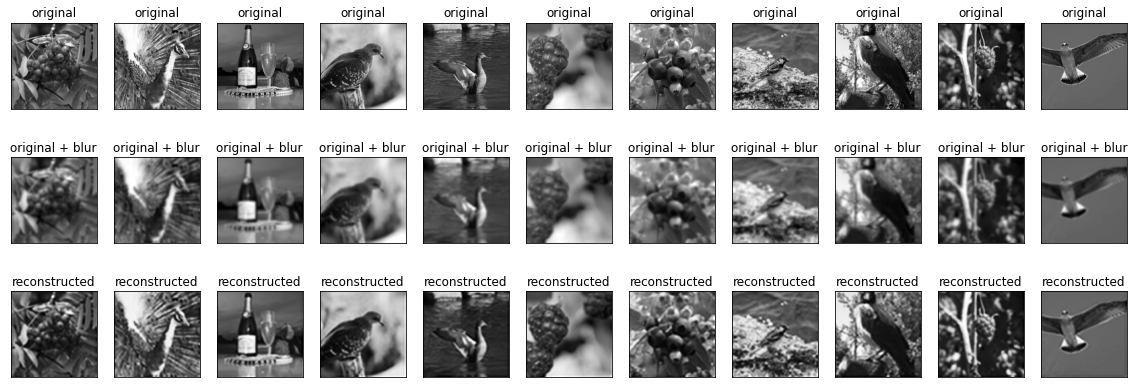

In [291]:

plt.figure(figsize=(20, 7))
plt.gray()
for i in range(11): 
  # display original 
  bx = plt.subplot(3, 11, i + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(org[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False)

  # display original + noise 
  cx = plt.subplot(3, 11, i + 11 + 1) 
  plt.title("original + blur") 
  plt.imshow(tf.squeeze(blur[i])) 
  cx.get_xaxis().set_visible(False) 
  cx.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  ax = plt.subplot(3,11, i + 2*11 + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(preds[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 

plt.show()

In [341]:
destroyed_image= tf.convert_to_tensor(n_test, dtype=tf.float32)
clean_image=tf.convert_to_tensor(org, dtype=tf.float32)
reconstructed_image=tf.convert_to_tensor(preds_c.reshape(-1,128,128,1), dtype=tf.float32)

In [342]:
p1=[]
p2=[]
ps1=[]
ps2=[]

In [343]:

ssim1= tf.image.ssim(reconstructed_image , clean_image, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
a1= tf.reduce_sum(ssim1)
b1= tf.size(ssim1)
ps1.append(a1.numpy()/b1.numpy())
ssim2 = tf.image.ssim(destroyed_image,clean_image, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
c1= tf.reduce_sum(ssim2)
d1= tf.size(ssim2)
ps2.append(c1.numpy()/d1.numpy())

In [344]:
psnr1 = tf.image.psnr(clean_image, reconstructed_image, max_val=1.0)
a=tf.reduce_sum(psnr1)
b=tf.size(psnr1)
p1.append(a.numpy()/b.numpy())
psnr2 = tf.image.psnr(clean_image,destroyed_image,max_val=1.0)
c=tf.reduce_sum(psnr2)
d=tf.size(psnr2)
p2.append(c.numpy()/d.numpy())

In [345]:
print(p1,p2)
print(ps1,ps2)

[20.23440673828125] [16.817191162109374]
[0.4381826782226563] [0.3368804931640625]


In [297]:
test_noise = addGaussNoiseTest(x_test)


In [298]:
noise = test_noise[temp]
preds_n = noise_model.predict(noise.reshape(-1, 128, 128, 1))
preds_n = preds_n.reshape(-1, 128, 128)


just checking conv noise model with only noise added

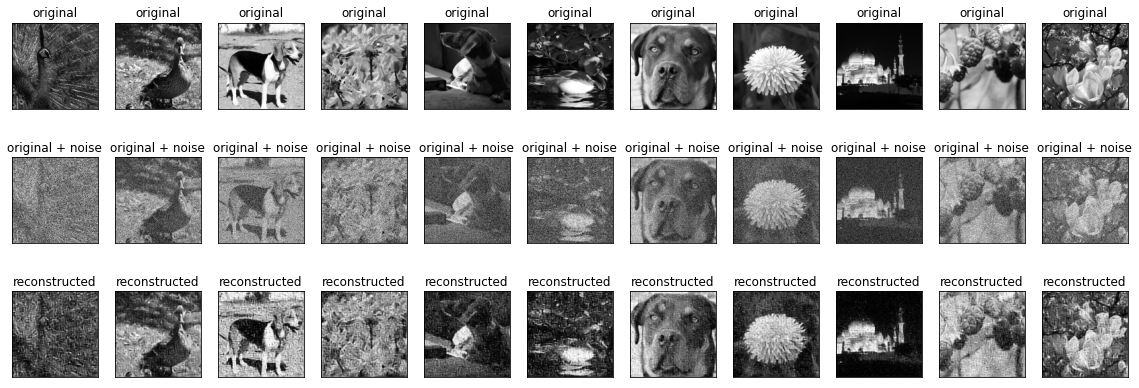

In [340]:

plt.figure(figsize=(20, 7))
plt.gray()
for i in range(11): 
  # display original 
  bx = plt.subplot(3, 11, i + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(org[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False)

  # display original + noise 
  cx = plt.subplot(3, 11, i + 11 + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(n_test[i])) 
  cx.get_xaxis().set_visible(False) 
  cx.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  ax = plt.subplot(3, 11, i + 2*11 + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(preds_c[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
 

plt.show()

In [308]:
p1=[]
p2=[]

1.testing on sequential simple autoencoder models                                
first added gaussian noise then blurred                                      
first denoising then deblurring

In [ ]:
n_test = addGaussNoiseTest(x_test)
b_test = add_blur_test(n_test)
combine = b_test
preds_n = noise_model.predict(combine.reshape(-1, 128, 128, 1))
preds_n = preds_n.reshape(-1, 128, 128)
preds_c = blur_model.predict(preds_n.reshape(-1, 128, 128, 1))
preds_c = preds_c.reshape(-1, 128, 128)

2.testing on sequential simple autoencoder models                
first added gaussian noise then blurred                                      
first deblur then denoise

In [ ]:
n_test = addGaussNoiseTest(x_test)
b_test = add_blur_test(n_test)
combine = b_test
preds_n = blur_model.predict(combine.reshape(-1, 128, 128, 1))
preds_n = preds_n.reshape(-1, 128, 128)
preds_c = noise_model.predict(preds_n.reshape(-1, 128, 128, 1))
preds_c = preds_c.reshape(-1, 128, 128)

3.testing on the simple conv models

adding noise    adding blur twice      

 first denoise then deblur                                                               

In [ ]:
n_test = addGaussNoiseTest(x_test)
b_test = add_blur_test(n_test)
b_test2 = add_blur_test(b_test)
combine = b_test2
preds_n = noise_model.predict(combine.reshape(-1, 128, 128, 1))
preds_n = preds_n.reshape(-1, 128, 128)
preds_c = blur_model.predict(preds_n.reshape(-1, 128, 128, 1))
preds_c = preds_c.reshape(-1, 128, 128)

4.testing on the simple conv models

adding noise adding blur twice

first deblurring then denoising

In [ ]:
n_test = addGaussNoiseTest(x_test)
b_test = add_blur_test(n_test)
b_test2 = add_blur_test(b_test)
combine = b_test2
preds_n = blur_model.predict(combine.reshape(-1, 128, 128, 1))
preds_n = preds_n.reshape(-1, 128, 128)
preds_c = noise_model.predict(preds_n.reshape(-1, 128, 128, 1))
preds_c = preds_c.reshape(-1, 128, 128)

5.testing on the simple conv models

adding noise twice adding blur 

first deblurring then denoising

In [ ]:
n_test = addGaussNoiseTest(x_test)
b_test = addGaussNoiseTest(n_test)
b_test2 = add_blur_test(b_test)
combine = b_test2
preds_n = blur_model.predict(combine.reshape(-1, 128, 128, 1))
preds_n = preds_n.reshape(-1, 128, 128)
preds_c = noise_model.predict(preds_n.reshape(-1, 128, 128, 1))
preds_c = preds_c.reshape(-1, 128, 128)

6.testing on the simple conv models

adding noise twice adding blur

first  denoising then deblurring 

In [ ]:
n_test = addGaussNoiseTest(x_test)
b_test = addGaussNoiseTest(n_test)
b_test2 = add_blur_test(b_test)
combine = b_test2
preds_n = noise_model.predict(combine.reshape(-1, 128, 128, 1))
preds_n = preds_n.reshape(-1, 128, 128)
preds_c = blur_model.predict(preds_n.reshape(-1, 128, 128, 1))
preds_c = preds_c.reshape(-1, 128, 128)

In [ ]:
ps1=[]
ps2=[]

In [ ]:
destroyed_image= tf.convert_to_tensor(combine, dtype=tf.float32)
clean_image=tf.convert_to_tensor(x_test, dtype=tf.float32)
reconstructed_image=tf.convert_to_tensor(preds_c.reshape(-1,128,128,1), dtype=tf.float32)

In [ ]:
ssim1= tf.image.ssim(reconstructed_image , clean_image, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
a1= tf.reduce_sum(ssim1)
b1= tf.size(ssim1)
ps1.append(a1.numpy()/b1.numpy())
ssim2 = tf.image.ssim(destroyed_image,clean_image, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
c1= tf.reduce_sum(ssim2)
d1= tf.size(ssim2)
ps2.append(c1.numpy()/d1.numpy())

In [ ]:
print(ps1,ps2)

[0.717720458984375, 0.760326904296875, 0.6439581298828125, 0.6722699584960937, 0.7520050048828125, 0.7109841918945312] [0.7526275634765625, 0.7526152954101563, 0.6642981567382813, 0.6643167724609375, 0.7415860595703125, 0.7414190063476562]


In [ ]:
psnr1 = tf.image.psnr(clean_image, reconstructed_image, max_val=1.0)
a=tf.reduce_sum(psnr1)
b=tf.size(psnr1)
p1.append(a.numpy()/b.numpy())
psnr2 = tf.image.psnr(clean_image,destroyed_image,max_val=1.0)
c=tf.reduce_sum(psnr2)
d=tf.size(psnr2)
p2.append(c.numpy()/d.numpy())

In [ ]:
print(p1,p2)

[24.751935546875, 25.3052890625, 23.547009765625, 23.83448046875, 25.13639453125, 24.625232421875] [25.30731640625, 25.30494140625, 23.649263671875, 23.6498203125, 25.170287109375, 25.163955078125]


In [ ]:
p2

[23.863302734375,
 23.86721875,
 23.034501953125,
 23.03263671875,
 22.74264453125,
 22.740666015625]

In [333]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

In [334]:
from torchvision.models import resnet50
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        res50_model = resnet50(pretrained=True)
        self.res50_conv = nn.Sequential(*list(res50_model.children())[:6])
        self.res50_conv[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.res50_conv(x)
        x = self.decoder(x)
        return x

In [335]:
import copy 
model = Autoencoder()
best_loss=100

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

testing on resnet with gaussian noise

In [336]:
checkpoint = torch.load('/content/drive/MyDrive/res_gauss.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
epochs = checkpoint['epoch']


Previously trained model weights state_dict loaded...


In [ ]:
x1 = addGaussNoiseTest(x_train) 
xt1 = addGaussNoiseTest(x_test)
x_train_noisy=x1
x_test_noisy=xt1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_test = x_test[:, None, :,:]
x_train = x_train[:, None, :, :]
noise_factor = 0.1
x1 = x_train + np.array(noise_factor * torch.normal(0, 1, size=x_train.shape))
xt1 = x_test + np.array(noise_factor * torch.normal(0, 1, size=x_test.shape))
x_train_noisy=x1
x_test_noisy=xt1
x_test_noisy=x_test_noisy.squeeze()
print(x_test_noisy.shape)
print(x_test_noisy.shape)
x_test_noisy=x_test_noisy[...,tf.newaxis]
b_test = add_blur_test(x_test_noisy)
b_test=b_test.squeeze()
b_test=b_test[:, None, :, :]

In [ ]:
p1=[]
p2=[]

In [ ]:
#utility function to pick samples to be tested
def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp
num = 300
org, temp = get_samples(x_test, num)

1. Autoencoder Deblurring and  Resnet optimised Denoiser trained with gaussian noise                                                      
Add noise → Add blur                               
Denoise → Deblur


In [ ]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
b_test = add_blur_test(n_test)
b_test=b_test.squeeze()
b_test=b_test[:, None, :, :]
output=[]
criterion = nn.MSELoss() # mean square error loss                                         shuffle=False)
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img[None, :, :,:]))
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()[...,tf.newaxis]
preds_c = blur_model.predict(tf_tensor)
preds_c = preds_c.reshape(-1, 128, 128)

2Add noise → Add blur
	Deblur → Denoise


In [ ]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
b_test = add_blur_test(n_test)
b_test = blur_model.predict(b_test)
output=[]
criterion = nn.MSELoss()
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img.squeeze()[None, None,:]))
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()
preds_c = tf_tensor

3.Add noise → Add blur → Add blur
	Denoise → Deblur


In [ ]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
b_test = add_blur_test(n_test)
b_test = add_blur_test(b_test)
b_test=b_test.squeeze()
b_test=b_test[:, None, :, :]
output=[]
criterion = nn.MSELoss() # mean square error loss                                         shuffle=False)
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img[None, :, :,:]))
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()[...,tf.newaxis]
preds_c = blur_model.predict(tf_tensor)
preds_c = preds_c.reshape(-1, 128, 128)

4.Add noise → Add blur → Add blur
	Deblur → Denoise


In [ ]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
b_test = add_blur_test(n_test)
b_test = add_blur_test(b_test)
b_test = blur_model.predict(b_test)
output=[]
criterion = nn.MSELoss()
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img.squeeze()[None, None,:]))
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()
preds_c = tf_tensor

5. Add noise→ Add Noise → Add blur
	Deblur → Denoise


In [ ]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
n_test = addGaussNoiseTest(n_test)
b_test = add_blur_test(n_test)
b_test = blur_model.predict(b_test)
output=[]
criterion = nn.MSELoss()
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img.squeeze()[None, None,:]))
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()
preds_c = tf_tensor

6.Add noise→ Add Noise → Add blur

In [ ]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
n_test =addGaussNoiseTest(n_test)
b_test = add_blur_test(n_test)
b_test=b_test.squeeze()
b_test=b_test[:, None, :, :]
output=[]
criterion = nn.MSELoss() # mean square error loss                                         shuffle=False)
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img[None, :, :,:]))
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()[...,tf.newaxis]
preds_c = blur_model.predict(tf_tensor)
preds_c = preds_c.reshape(-1, 128, 128)

In [ ]:
p1=[]
p2=[]

In [ ]:
destroyed_image= tf.convert_to_tensor(b_test.reshape(-1,128,128,1), dtype=tf.float32)
clean_image=tf.convert_to_tensor(org, dtype=tf.float32)
reconstructed_image=tf.convert_to_tensor(preds_c.reshape(-1,128,128,1), dtype=tf.float32)

In [ ]:

psnr1 = tf.image.psnr(clean_image, reconstructed_image, max_val=1.0)
a=tf.reduce_sum(psnr1)
b=tf.size(psnr1)
p1.append(a.numpy()/b.numpy())
psnr2 = tf.image.psnr(clean_image,destroyed_image,max_val=1.0)
c=tf.reduce_sum(psnr2)
d=tf.size(psnr2)
p2.append(c.numpy()/d.numpy())


In [ ]:
print(p1,p2)

[23.279814453125, 24.80166015625, 22.370771484375, 23.419547526041665, 24.595143229166666, 23.125328776041666] [25.263653971354167, 25.9284765625, 23.584239908854165, 24.311564127604168, 25.56125, 25.118889973958332]


In [ ]:
ssim1= tf.image.ssim(reconstructed_image , clean_image, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
a1= tf.reduce_sum(ssim1)
b1= tf.size(ssim1)
ps1.append(a1.numpy()/b1.numpy())
ssim2 = tf.image.ssim(destroyed_image,clean_image, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
c1= tf.reduce_sum(ssim2)
d1= tf.size(ssim2)
ps2.append(c1.numpy()/d1.numpy())

In [ ]:
print(ps1,ps2)

[0.6064634195963542, 0.7168281555175782, 0.5371126302083333, 0.6341109212239583, 0.703840840657552, 0.5959615071614583] [0.7581377156575521, 0.8092752075195313, 0.6695289611816406, 0.7277279154459635, 0.784454345703125, 0.746283213297526]


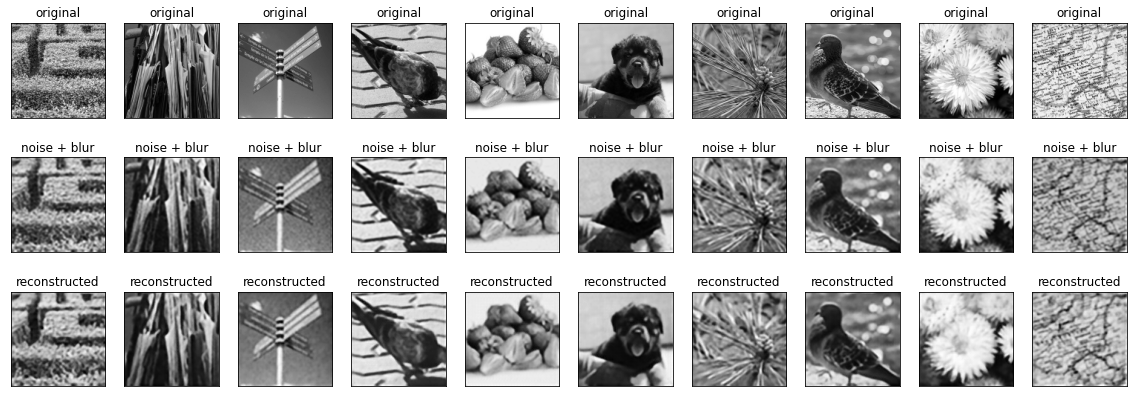

In [281]:

plt.figure(figsize=(20, 7))
plt.gray()
for i in range(10): 
  # display original 
  bx = plt.subplot(3, 10, i + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(org[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False)

  # display original + noise 
  cx = plt.subplot(3, 10, i + 10 + 1) 
  plt.title("noise + blur") 
  plt.imshow(tf.squeeze(b_test[i])) 
  cx.get_xaxis().set_visible(False) 
  cx.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  ax = plt.subplot(3, 10, i + 2*10 + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(preds_c[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
 

plt.show()

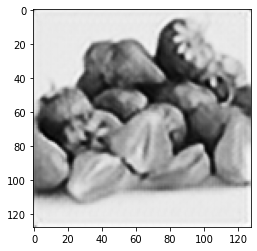

In [241]:
  plt.imshow(tf.squeeze(preds_c[4])) 


In [14]:
! cp /content/drive/MyDrive/Config.py .
! cp /content/drive/MyDrive/unet_model.py .

In [15]:
import cv2
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
import os 
import torchvision.transforms.functional as tvF
from unet_model import UNet
from Config import Config as conf
import time
#from data_set_builder import Training_Dataset

from torch.utils.data import Dataset, DataLoader
#from data_set_builder import Testinging_Dataset
from torch.utils.data import Dataset, DataLoader
import numpy as np
from skimage import io

In [16]:

model = UNet(in_channels =conf.img_channel,out_channels=conf.img_channel)
criterion = nn.MSELoss()
optim = Adam(model.parameters(), lr = conf.learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=True)
scheduler = lr_scheduler.StepLR(optim, step_size=100, gamma=0.5)

In [17]:
use_gpu = torch.cuda.is_available()
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()


In [18]:
torch.cuda.is_available()

True

In [20]:
path='/content/drive/MyDrive/denoise_epoch_5.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
 torch.cuda.empty_cache()

In [34]:
#utility function to pick samples to be tested
def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp
num = 100
org, temp = get_samples(x_test, num)

#1


In [243]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
b_test = add_blur_test(n_test)
b_test=b_test.squeeze()
b_test=b_test[:, None, :, :]
output=[]
criterion = nn.MSELoss() # mean square error loss                                         shuffle=False)
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 101:
      break
    recon = model(torch.from_numpy(img[None, :, :,:]).cuda())
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.cpu().detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()[...,tf.newaxis]
preds_c = blur_model.predict(tf_tensor)
preds_c = preds_c.reshape(-1, 128, 128)

#2

In [280]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
b_test = add_blur_test(n_test)
b_test = blur_model.predict(b_test)
output=[]
criterion = nn.MSELoss()
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 101:
      break
    recon = model(torch.from_numpy(img.squeeze()[None, None,:]).cuda())
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.cpu().detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()
preds_c = tf_tensor

#3

In [256]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
b_test = add_blur_test(n_test)
b_test = add_blur_test(b_test)
b_test=b_test.squeeze()
b_test=b_test[:, None, :, :]
output=[]
criterion = nn.MSELoss() # mean square error loss                                         shuffle=False)
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 101:
      break
    recon = model(torch.from_numpy(img[None, :, :,:]).cuda())
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.cpu().detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()[...,tf.newaxis]
preds_c = blur_model.predict(tf_tensor)
preds_c = preds_c.reshape(-1, 128, 128)

#4

In [262]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
b_test = add_blur_test(n_test)
b_test = add_blur_test(b_test)
b_test = blur_model.predict(b_test)
output=[]
criterion = nn.MSELoss()
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img.squeeze()[None, None,:]).cuda())
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.cpu().detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()
preds_c = tf_tensor

#5

In [268]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
n_test = addGaussNoiseTest(n_test)
b_test = add_blur_test(n_test)
b_test = blur_model.predict(b_test)
output=[]
criterion = nn.MSELoss()
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img.squeeze()[None, None,:]).cuda())
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.cpu().detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()
preds_c = tf_tensor

#6

In [274]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
n_test =addGaussNoiseTest(n_test)
b_test = add_blur_test(n_test)
b_test=b_test.squeeze()
b_test=b_test[:, None, :, :]
output=[]
criterion = nn.MSELoss() # mean square error loss                                         shuffle=False)
outputs = []
model.eval()
count = 0
for img in b_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img[None, :, :,:]).cuda())
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.cpu().detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()[...,tf.newaxis]
preds_c = blur_model.predict(tf_tensor)
preds_c = preds_c.reshape(-1, 128, 128)

In [244]:
p1=[]
p2=[]
ps1=[]
ps2=[]

In [275]:
destroyed_image= tf.convert_to_tensor(b_test.reshape(-1,128,128,1), dtype=tf.float32)
clean_image=tf.convert_to_tensor(org, dtype=tf.float32)
reconstructed_image=tf.convert_to_tensor(preds_c.reshape(-1,128,128,1), dtype=tf.float32)

In [276]:
ssim1= tf.image.ssim(reconstructed_image , clean_image, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
a1= tf.reduce_sum(ssim1)
b1= tf.size(ssim1)
ps1.append(a1.numpy()/b1.numpy())
ssim2 = tf.image.ssim(destroyed_image,clean_image, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
c1= tf.reduce_sum(ssim2)
d1= tf.size(ssim2)
ps2.append(c1.numpy()/d1.numpy())

In [277]:
print(ps1,ps2)

[0.7573300933837891, 0.776317367553711, 0.6704167938232422, 0.6813839721679688, 0.7637518310546875, 0.7496524810791015] [0.734124526977539, 0.7976033020019532, 0.6441606140136719, 0.707323226928711, 0.7744117736816406, 0.7276636505126953]


In [278]:

psnr1 = tf.image.psnr(clean_image, reconstructed_image, max_val=1.0)
a=tf.reduce_sum(psnr1)
b=tf.size(psnr1)
p1.append(a.numpy()/b.numpy())
psnr2 = tf.image.psnr(clean_image,destroyed_image,max_val=1.0)
c=tf.reduce_sum(psnr2)
d=tf.size(psnr2)
p2.append(c.numpy()/d.numpy())


In [279]:
print(p1,p2)

[25.101982421875, 25.41788818359375, 23.70263671875, 23.9148974609375, 25.18797119140625, 24.97324462890625] [24.891337890625, 25.7136669921875, 23.295341796875, 24.109716796875, 25.35594482421875, 24.8041455078125]


In [323]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
#n_test = addGaussNoiseTest(n_test)
output=[]
criterion = nn.MSELoss()
outputs = []
model.eval()
count = 0
for img in n_test:
    count += 1
    if count == 101:
      break
    recon = model(torch.from_numpy(img.squeeze()[None, None,:]).cuda())
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.cpu().detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()
preds_c = tf_tensor

RuntimeError: ignored

In [339]:
n_test = addGaussNoiseTest(org.reshape(-1, 128, 128, 1))
output=[]
criterion = nn.MSELoss()
outputs = []
model.eval()
count = 0
for img in n_test:
    count += 1
    if count == 301:
      break
    recon = model(torch.from_numpy(img.squeeze()[None, None,:]))
    output.append(recon)
tf_tensor=[]
for i in output: 
  tf_tensor.append(tf.convert_to_tensor(i.detach().numpy().astype('float32')))
tf_tensor=np.array(tf_tensor)
tf_tensor=tf_tensor.squeeze()
preds_c = tf_tensor